In [1]:
import urllib
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import json
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

# 셀렉터 테스트 여러 페이지
### **여러 검색어를 찾아옵니다.**

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
driver = webdriver.Chrome('C:/Temp/chromedriver')

In [ ]:
#driver = webdriver.Chrome('C:/Temp/chromedriver')

In [ ]:
# 구글 crawling 함수 선언
def google_crawling(word):
    # 데이터 각 각 담을 리스트 변수 선언
    company, title, article, date = [], [], [], []
    # 페이지 이동을 위한 Page 번호
    startPage = 0  #endPage = 100
    while True:
        try : 
            driver.get(f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start={startPage}&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1')
            driver.implicitly_wait(3)
        except :
            break
        else :
            dataList = []
            i = 1
            # 한페이지에 10개 이하만 표시될 경우 오류 발생
            # while True문으로 변경
            while True:               
#             for i in range(1, 11):
                try :
                    cssSelector = f"#rso > div:nth-child({i}) > g-card > div > div > a > div > div.iRPxbe"
                    dataList.append(driver.find_element_by_css_selector(cssSelector).text)
                except :
                    break
                else :
                    i += 1
            # 기사가 없어도 startPage 값이 계속 올라가서 무한 루프 도는 현상 해결
            # 기사 없을 때 저장&Break
            if len(dataList) == 0 :
                # 데이터 프레임 저장하기
                # data/nver_crawl/검색년도-검색월-검색일_keywore_goole.csv로 저장하기
                data = pd.DataFrame({'company' : company, 'title' : title, 'article' : article, 'date' : date})
                searchDate = time.strftime('%Y-%m-%d', time.localtime(time.time()))
                data.to_csv("data/google_crawl/" + searchDate +"_"+ word + "_goole.csv", index=False)
                break
            # "\n"으로 나누기
            tempList = []
            for data in dataList:
                temps = data.split('\n')
                for temp in temps:
                    if temp != "." :
                        tempList.append(temp)
            # 언론사, 뉴스제목, 뉴스요약기사, 발행일 분리
            for i, temp in enumerate(tempList):
                if i % 4 == 0 :
                    company.append(temp)
                elif i % 4 == 1:
                    title.append(temp)
                elif i % 4 == 2:
                    article.append(temp)
                else:
                    date.append(temp)
    #         # 반복문 끝
    #         if endPage == startPage:
    #             break
            startPage += 10

In [ ]:
keyword = ['요양원', '요양시설']
for s in keyword :
    google_crawling(s)

# 형태소분석

In [ ]:
from konlpy.tag import Kkma
sample = '이것은 형태소 분석기 입니다 아버지가방에들어가신다'
kkma = Kkma()
print(kkma.nouns(sample))

In [ ]:
## PPT엔 요양시설 검색결과 사용 XX
data = pd.read_csv("data/google_crawl/2021-11-11_요양시설_goole.csv")
nounsList = []
kkma = Kkma()
for i in range(len(data)):
    titleNoun = kkma.nouns(data.loc[i, "title"])
    #articleNoun = kkma.nouns(data.loc[i, "article"])
    nounsList.append(titleNoun)
    #nounsList.append(articleNoun)
# 이중리스트 풀기
nounsList = [y for x in nounsList for y in x]
nounsList = [noun for noun in nounsList if (len(noun) >= 2) and noun.isdigit()==False ]

In [ ]:
data2 = pd.read_csv("data/google_crawl/2021-11-11_요양원_goole.csv")
nounsList = []
kkma = Kkma()
for i in range(len(data)):
    titleNoun = kkma.nouns(data.loc[i, "title"])
    #articleNoun = kkma.nouns(data.loc[i, "article"])
    nounsList.append(titleNoun)
    #nounsList.append(articleNoun)
# 이중리스트 풀기
nounsList = [y for x in nounsList for y in x]
nounsList = [noun for noun in nounsList if (len(noun) >= 2) and noun.isdigit()==False ]

# 빈도수 만들기

In [2]:
import nltk     
from konlpy.tag import Okt 
from konlpy.tag import Kkma
from nltk.tokenize import word_tokenize 

In [34]:
data1 = pd.read_csv("data/google_crawl/2021-11-11_요양시설_goole.csv")
data2 = pd.read_csv("data/google_crawl/2021-11-11_요양원_goole.csv")

def make_Freq_df(data) :
    #형태소 분석
    nounsList = []
    kkma = Kkma()
    for i in range(len(data)):
        titleNoun = kkma.nouns(data.loc[i, "title"])
        #articleNoun = kkma.nouns(data.loc[i, "article"])
        nounsList.append(titleNoun)
        #nounsList.append(articleNoun)
    # 이중리스트 풀기
    nounsList = [y for x in nounsList for y in x]
    nounsList = [noun for noun in nounsList if (len(noun) >= 2) and noun.isdigit()==False ]
    
    #nltk.Text로 Text 객체 생성
    nouns_text = nltk.Text(nounsList) 

    # DataFrame으로 만들기
    FreqDf = pd.DataFrame(nouns_text.vocab().most_common(), columns=['word', 'freq'])
    return FreqDf.set_index('word').head(10)

In [36]:
# 불용어 설정 (불용어 추가 : txt파일 수정)
# 출처 = https://www.ranks.nl/stopwords
stop_words = pd.read_csv('data/stop_words.txt', sep='\n',header=None)
print(stop_words.head())
stopList = []
for i in range(len(stop_words)) :
    stopList.append(stop_words[0][i])
print(stopList[10])

     0
0    아
1    휴
2  아이구
3  아이쿠
4  아이고


In [35]:
data1_Freq = make_Freq_df(data1)
data2_Freq = make_Freq_df(data2)

In [39]:
display(data1_Freq)

,freq
word,
요양,243
시설,228
요양시설,137
노인,73
병원,57
노인요양시설,54
감염,51
코로나,43
요양병원,42


In [40]:
display(data2_Freq)

,freq
word,
요양원,246
감염,51
요양,47
집단,34
코로나,33
집단감염,30
노인,29
케어,22
치매,21


# 워드 클라우드

In [48]:
data2 = pd.read_csv("data/google_crawl/2021-11-11_요양원_goole.csv")
nounsList = []
kkma = Kkma()
for i in range(len(data)):
    titleNoun = kkma.nouns(data.loc[i, "title"])
    #articleNoun = kkma.nouns(data.loc[i, "article"])
    nounsList.append(titleNoun)
    #nounsList.append(articleNoun)
# 이중리스트 풀기
nounsList = [y for x in nounsList for y in x]
nounsList = [noun for noun in nounsList if (len(noun) >= 2) and noun.isdigit()==False ]
nounsString = ' '.join(nounsList)

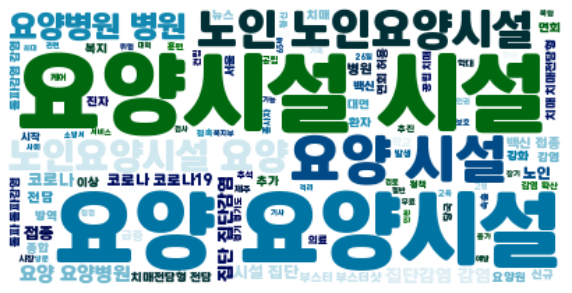

In [49]:
# 팀원 간 폰트 결정
# myfontpath = "./data/font/NanumMyeongjo.ttf" 
myfontpath = "./font/a프로젝트.ttf"
plt.figure(figsize=(10,6))
wc = WordCloud(font_path = myfontpath, background_color="white", 
               contour_width=5, contour_color="royalblue",
               colormap = 'ocean')
wc.generate(nounsString)
wc.to_file('output/goole_wordcloud.png')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


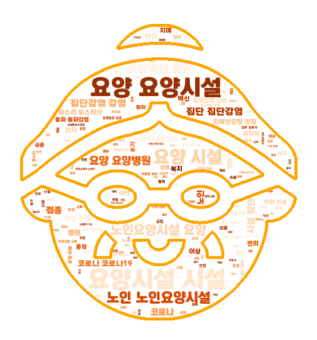

In [50]:
from PIL import Image
myfontpath = "./data/font/a프로젝트.ttf"
plt.figure(figsize=(10,6))
custom_mask = np.array(Image.open("./data/images/할머니.png"))
wc = WordCloud(font_path = myfontpath, background_color="white",
               mask=custom_mask, contour_width=5, contour_color="orange",
               colormap = 'Oranges')
wc.generate(nounsString)
wc.to_file('./output/wordcloud_할머니.png')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 함수 만들기

---

---
# ▼버려진 코드▼
---

In [30]:
# 공백을 사이에 두고 클자 합침
nounsString = ' '.join(nounsList)

In [38]:
#Okt.morphs() 로 토큰화 하는 방법
word_tokens2 = t.morphs(nounsString)
#print(word_tokens2[:10])
result2 = [] 
for w in word_tokens2: 
    if w not in stopList: 
        result2.append(w) 
print(result2[:30])    

['서울', '진자', '1000', '1000', '명대', '대', '노', '집단', '집단', '감염', '감염', '종합', '감염', '감염', '경로', '별', '경로', '별', '노원', '노원구', '소재', '관련', '진자', '17', '17', '신규', '발생', '총', '19', '19']


In [10]:
#Okt.nouns() + nltk.Text.vocab() 로 토큰화 하는 방법
t = Okt()
word_tokens1 = t.nouns(nounsString)                ## 텍스트에서 명사를 추출한다. 
print(word_tokens1[:10])

#Okt.nouns 쓰지 말고 위 Kkma를 했던 nounList를 쓰기
# result1 = [] 
# for w in word_tokens1: 
#     if w not in stopList: 
#         result1.append(w) 



['서울', '진자', '명대', '명', '노', '요양', '요양', '시설', '시설', '집단']
[('요양', 516), ('시설', 501), ('요양시설', 290), ('노인', 175), ('병원', 150), ('코로나', 123), ('요양병원', 122), ('노인요양시설', 118), ('감염', 117), ('명', 96), ('19', 96), ('등', 95), ('코로나19', 93), ('일', 88), ('접종', 86), ('집단', 77), ('집단감염', 64), ('시', 64), ('치매', 63), ('백신', 53), ('요양원', 48), ('진자', 47), ('전담', 45), ('진', 44), ('종사자', 42), ('기자', 40), ('면회', 40), ('환자', 38), ('추가', 37), ('월', 37)]


In [7]:
print(len(nouns_text.tokens))
print(len(set(nouns_text.tokens))) 

11818
1833


['서울', '진자', '명대', '명', '노', '요양', '요양', '시설', '시설', '집단']


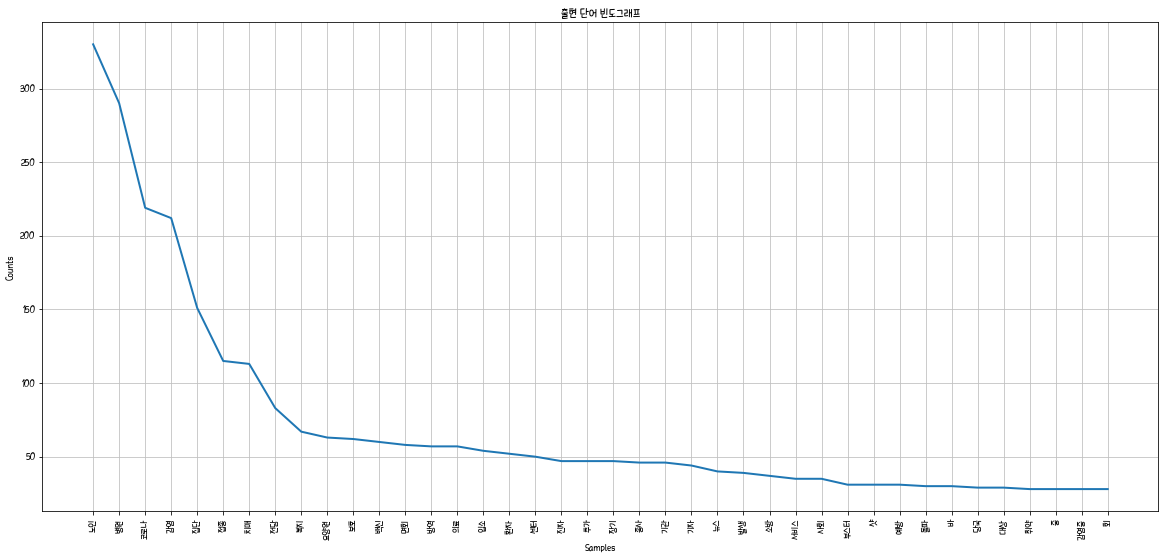

In [48]:
from matplotlib import font_manager, rc
font_path = "data/font/Thedog.ttf"   #폰트파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 그래프 바꾸는 방법 찾아봐야함 _ 수업 예제 중에선 선그래프밖에 없음.
#https://tedboy.github.io/nlps/generated/generated/nltk.FreqDist.plot.html#nltk.FreqDist.plot -> plot의 args 중 막대그래프 속성 못찾음
# 한글 깨짐현상

plt.figure(figsize=(20,9))
plt.title("출현 단어 빈도그래프")
plt.ylabel('횟수')
plt.xlabel('단어')
nouns_text.plot(40)   

In [38]:
data1_Freq.to_excel("output/google_요양시설_Freq.xlsx", encoding='utf-8')
data2_Freq.to_excel("output/google_요양원_Freq.xlsx", encoding='utf-8')
# index_label=data1_Freq.index(),columns='freq'

## 셀렉터 테스트 첫번째 페이지

In [ ]:
print(urllib.parse.quote("요양원"))
driver.get(f'https://www.google.com/search?q={urllib.parse.quote("요양원")}&sxsrf=AOaemvIg7vtIYt-lq_znIu_01EmjUVdDmQ:1636592131615&source=lnms&tbm=nws&sa=X&ved=2ahUKEwig-5XljI_0AhVhh1YBHZSxBzoQ_AUoA3oECAMQBQ&biw=1920&bih=937&dpr=1')

In [ ]:
'#rso > div:nth-child(1) > g-card > div > div > a > div > div.iRPxbe >'
company, title, article = [],[],[]
#div_path = '#rso > div:nth-child(1) > g-card > div > div > a > div > div.iRPxbe >'
c_path = " div.QyR1Ze BA0A6c"
t_path = " div.mCBkyc.tNxQIb.ynAwRc.JIFdL.JQe2Ld.nDgy9d"
a_path = " div.GI74Re nDgy9d"

driver.get(f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start=0&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1')
driver.implicitly_wait(3)
for i in range(1,11) :
    div_path = f'#rso > div:nth-child({i}) > g-card > div > div > a > div > div.iRPxbe >'
    company.append(driver.find_element_by_css_selector(div_path+c_path).text)
    title.append(driver.find_element_by_css_selector(div_path+t_path).text)
    article.append(driver.find_element_by_css_selector(div_path+a_path).text)

In [ ]:
res = requests.get(f'https://www.google.com/search?q={urllib.parse.quote("요양원")}&sxsrf=AOaemvIg7vtIYt-lq_znIu_01EmjUVdDmQ:1636592131615&source=lnms&tbm=nws&sa=X&ved=2ahUKEwig-5XljI_0AhVhh1YBHZSxBzoQ_AUoA3oECAMQBQ&biw=1920&bih=937&dpr=1')
soup = BeautifulSoup(res.content, 'html.parser')
title = soup.select("div.QyR1Ze BA0A6c > span")
print(
for t in title :
    print(t.get_text())

In [ ]:
keyword = ['요양원', '요양시설']
company, title, article = [],[],[]
div_path = '//*[@id="rso"]/div[1]/g-card/div/div/a/div/div[2]'
//*[@id="rso"]/div[2]/g-card/div/div/a/div/div
for word in keyword :
    num=0
    while True :
        url = f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start='+str(num)+'&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1'
        print(url)
        driver.get(url)      
        driver.implicitly_wait(3)
        #byXPath = driver.find_element_by_xpath('//*[@id="rso"]')
        try :
            for i in range(1,11) :
                print(i)
                company.append(driver.find_element_by_xpath(div_path+str(i)+c_path).text)
                title.append(driver.find_element_by_xpath(div_path+str(i)+t_path).text)
                article.append(driver.find_element_by_xpath(div_path+str(i)+a_path).text)            
        except Exception as e:
            print(e)
            break
        num = num+10
            
        print('정상종료')

In [ ]:
# 확인하기
print(len(date), date)

In [ ]:
print(len(company))
print(len(title))
print(len(article))
print(len(date))

In [ ]:
# 데이터 프레임 저장하기
# data/nver_crawl/검색년도-검색월-검색일_keywore_goole.csv로 저장하기
searchDate = time.strftime('%Y-%m-%d', time.localtime(time.time()))
data.to_csv("google_crawl/" + searchDate + "_goole.csv", index=False)

In [ ]:
# 데이터 프레임 만들기
data = pd.DataFrame({'company' : company, 'title' : title, 'article' : article, 'date' : date})

In [ ]:
keyword = ['요양원', '요양시설']
company, title, article = [],[],[]
div_path = '//*[@id="rso"]/div['
c_path = "]/g-card/div/div/a/div/div/span"
t_path = "]/g-card/div/div/a/div/div[2]/div[2]"
a_path = "]/g-card/div/div/a/div/div[2]/div[3]"
for word in keyword :
    num=0
    while True :
        url = f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start='+str(num)+'&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1'
        print(url)
        driver.get(url)      
        driver.implicitly_wait(3)
        #byXPath = driver.find_element_by_xpath('//*[@id="rso"]')
        try :
            for i in range(1,11) :
                print(i)
                company.append(driver.find_element_by_xpath(div_path+str(i)+c_path).text)
                title.append(driver.find_element_by_xpath(div_path+str(i)+t_path).text)
                article.append(driver.find_element_by_xpath(div_path+str(i)+a_path).text)            
        except Exception as e:
            print(e)
            break
        num = num+10
            
        print('정상종료')

In [ ]:
print(company)
print(title)

In [ ]:
driver.quit()